# Extraction des polygones des départements de la région AURA

## Objectifs

Pour faire des cartes on va avoir besoin du tracé des différentes entités administratives. Ce notebook s'occupe des départements. Il ouvre le shapefile, le filtre selon le code insee et en réécrit un qui (normalement!) ne contient que les données qui nous intéressent, simplifiées de sorte à convenir à un site web.



## Instructions

Données à récupérer:
- https://www.data.gouv.fr/fr/datasets/contours-des-departements-francais-issus-d-openstreetmap/ à extraire dans ../data

## Notes

Dans les données que j'ai utilisé, deux entités séparées sont distinguées entre la métropole de Lyon (69M) et
le reste du département du Rhône (69D). Ce notebook contient dont une partie supplémentaire par rapport aux autres pour fusionner des deux géométries dans un même objet.

In [1]:
from shapely.ops import unary_union
from shapely.geometry import MultiPolygon, Polygon, mapping
import geopandas as gpd
import pandas as pd
import topojson as tp
import json
import re

In [2]:
depts_fr = gpd.read_file("../data/departements-20180101-shp/departements-20180101.shp", dtype={"code_insee": str})

In [3]:
in_AURA = [ i for i in range(len(depts_fr))
               if re.match("(01|03|07|15|26|38|42|43|63|69|73|74)", depts_fr.iloc[i].code_insee) ]

In [4]:
depts_aura = depts_fr.iloc[in_AURA]

<AxesSubplot:>

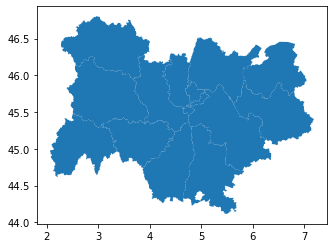

In [5]:
depts_aura.plot()

Truc un peu chiant: dans ces données le département du Rhône est coupé en deux départementd 69M et 69D (la métropole de Lyon est à part). Ce n'est pas le cas dans le dataset OSE, donc il faut les fusionner dans un seul et même département 69. Code un peu laborieux, sources:
- fusion de polygones https://www.matecdev.com/posts/shapely-merge-polygons.html
- convertion multilinestring => polygon https://stackoverflow.com/questions/2964751/how-to-convert-a-geos-multilinestring-to-polygon

In [6]:
D1=depts_aura.where(depts_aura['code_insee']=='69D')
D2=depts_aura.where(depts_aura['code_insee']=='69M')

In [7]:
polys = []
for G in [D1["geometry"], D2["geometry"]]:
    for k in G.geometry:
        if k is not None:
            if type(k) == MultiPolygon:
                polys += k.geoms
            elif type(k) == Polygon:
                polys.append(k)
            else:
                raise ValueError(f"unexpected type {type(k)}")

<AxesSubplot:>

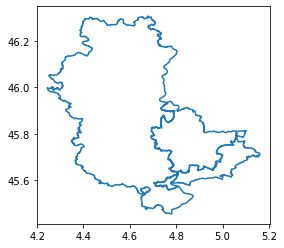

In [8]:
gpd.GeoSeries(polys).boundary.plot()

<AxesSubplot:>

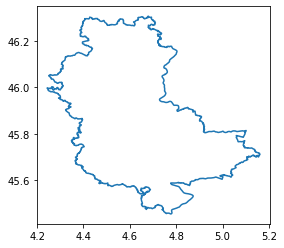

In [9]:
mergedPolys = unary_union(polys)
gpd.GeoSeries([mergedPolys]).boundary.plot()

In [10]:
new_row = {'code_insee':'69', 'nom':'Rhône', 'wikipedia':'fr:Rhône (département)', 'surf_km2':2720+538,
           'geometry':mergedPolys}
new_row = gpd.GeoDataFrame([new_row])
new_row.set_crs(D1["geometry"].crs)
depts_aura = pd.concat([depts_aura, new_row])
depts_aura.drop(depts_aura[depts_aura['code_insee'] == "69M"].index, inplace = True)
depts_aura.drop(depts_aura[depts_aura['code_insee'] == "69D"].index, inplace = True)

/home/thomas/.local/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [11]:
topo = tp.Topology(depts_aura.to_crs(4326), prequantize=False)
depts_aura_simple = topo.toposimplify(0.01).to_gdf()
depts_aura_simple = depts_aura_simple.rename(columns={"code_insee": "code_territoire"})
depts_aura_simple = depts_aura_simple.drop(columns=["wikipedia", "nuts3"])
depts_aura_simple.to_file("../data/depts_aura.geojson")

/home/thomas/.local/lib/python3.10/site-packages/topojson/core/dedup.py:107: RuntimeWarning: invalid value encountered in cast
  data["bookkeeping_shared_arcs"] = array_bk_sarcs.astype(np.int64).tolist()
